In [90]:
import pandas as pd
import sqlite3
import numpy as np
from shapely.geometry import Point
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

# my custom file
#import Mapping_tools

In [3]:
# FILE PATHS -- so we can each just comment out file paths

# ALEX'S PATHS
database_db = 'blue_bikes.db'
bike_lanes_geojson = 'bos-bike-paths-2022.geojson'
boston_city_shp = "Boston Neighborhoods/Boston_Neighborhoods.shp"
sea_level_9in_path = '9_inch_SLR_10_pct_storm/_9inch_Sea_Level_Rise_10pct_Annual_Flood.shp'
sea_level_21in_path = '21_inch_SLR_10_pct_storm/_21inch_Sea_Level_Rise_10pct_Annual_Flood.shp'
sea_level_36in_path = '36_inch_SLR_10_pct_storm/_36inch_Sea_Level_Rise_10pct_Annual_Flood.shp'
bike_lanes_geojson = 'bos-bike-paths-2022.geojson'
# ZACK'S PATHS
#database_db = '/Users/zacharyarmand/Documents/DS5110-blue-bikes/Data/blue_bikes.db'
#bike_lanes_geojson = '/Users/zacharyarmand/Documents/DS5110-blue-bikes/Data/bos-bike-paths-2022.geojson'
#boston_city_shp = "/Users/zacharyarmand/Documents/DS5110/Homeworks/Homework2/Boston_Neighborhoods/Boston_Neighborhoods.shp"
#sea_level_9in_path = '/Users/zacharyarmand/Documents/DS5110-blue-bikes/Data/9_inch_SLR_10_pct_storm/_9inch_Sea_Level_Rise_10pct_Annual_Flood.shp'
#sea_level_21in_path = '/Users/zacharyarmand/Documents/DS5110-blue-bikes/Data/21_inch_SLR_10_pct_storm/_21inch_Sea_Level_Rise__10pct_Annual_Flood.shp'
#sea_level_36in_path = '/Users/zacharyarmand/Documents/DS5110-blue-bikes/Data/36_inch_SLR_10_pct_storm/_36inch_Sea_Level_Rise_10pct_Annual_Flood.shp'


In [4]:
# Connection to database:
con = sqlite3.connect(database_db)

In [5]:
# Here are all the Views:
boston_crashes_2017 = pd.read_sql("SELECT * FROM boston_crash_reports_2017", con)
boston_crashes_2022 = pd.read_sql("SELECT * FROM boston_crash_reports_2022", con)
boston_fatalities_2017 = pd.read_sql("SELECT * FROM boston_fatality_report_2017", con)
boston_fatalities_2022 = pd.read_sql("SELECT * FROM boston_fatality_report_2022", con)
bike_5001 = pd.read_sql("SELECT * FROM bike_5001", con)

# Tables:
bluebike_trips2017 = pd.read_sql("SELECT * FROM bluebike_trips2017", con)
bluebike_trips2017 = pd.read_sql("SELECT * FROM bluebike_trips2022", con)
bluebike_trips2017 = pd.read_sql("SELECT * FROM boston_crash_reports", con)
bluebike_trips2017 = pd.read_sql("SELECT * FROM boston_fatality_report", con)
bluebike_trips2017 = pd.read_sql("SELECT * FROM current_bluebikes_stations", con)

Index(['dispatch_ts', 'mode_type', 'lat', 'long', 'geometry'], dtype='object')


<Axes: >

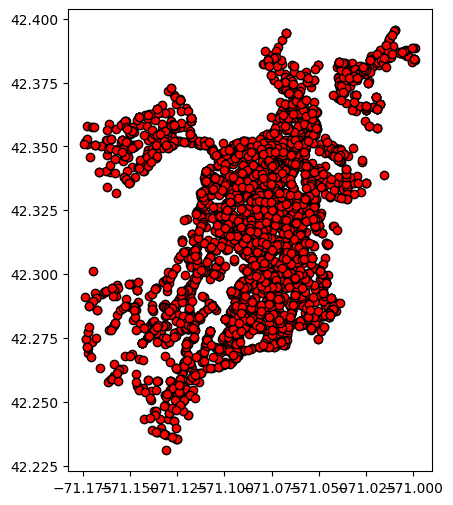

In [64]:
# Convert crime dataframe into a series of point objects
points = [Point(xy) for xy in zip(boston_crashes_2017['long'], boston_crashes_2017['lat'])]
# Convert that point layer into a geodataframe object
geodf = gpd.GeoDataFrame(boston_crashes_2017,
                             crs="EPSG:4326",
                             geometry=points)

print(geodf.columns)

# Only showing value less than 75 to remove outliers
fig, ax = plt.subplots(figsize=(7, 6))
#geodf.plot(color='#808080', edgecolor='#000000', ax=ax)  # background plot
# Plot data
geodf.plot( edgecolor='#000000',
          legend=True, categorical=False, ax=ax, color='r')

# Stuff We Like - so far? needs to be cleaned up still?

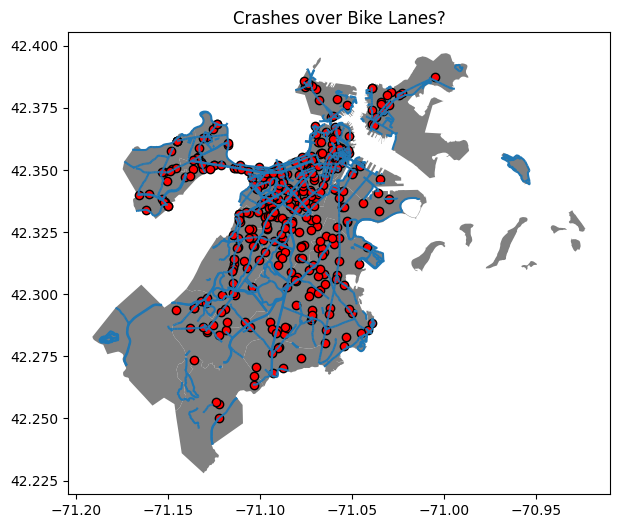

In [68]:
# Filter crash data to just bikes
bike_crashes_2017 = boston_crashes_2017[boston_crashes_2017["mode_type"] == 'bike'] 

# Mapping a dataframe with lat/long data to a point file
points = [Point(xy) for xy in zip(bike_crashes_2017['long'], bike_crashes_2017['lat'])]
# Convert that point layer into a geodataframe object
crashes_2017 = gpd.GeoDataFrame(bike_crashes_2017, crs="EPSG:4326", geometry=points)


# Read in bike lanes file
bike_lanes = gpd.read_file(bike_lanes_geojson)

# Add shapefile of Boston Neighborhoods https://data.boston.gov/dataset/boston-neighborhoods
boston_neighborhoods = gpd.read_file(boston_city_shp, type='Polygon')
boston_neighborhoods = boston_neighborhoods.to_crs('EPSG:4326')


# create figure
fig, ax = plt.subplots(figsize=(7, 7))
# Neighborhood background map
#nhoods.plot(color='#808080', edgecolor='#000000', ax=ax)  # background plot

# Plot background images
bike_lanes.plot(ax=ax)
boston_neighborhoods.plot(ax=ax, color='grey')

# Plot data
crashes_2017.plot(edgecolor='#000000', legend=True, categorical=False, ax=ax, color='r')
plt.title("Crashes over Bike Lanes?")
plt.show()

## Zack's Work In Progress Stuff

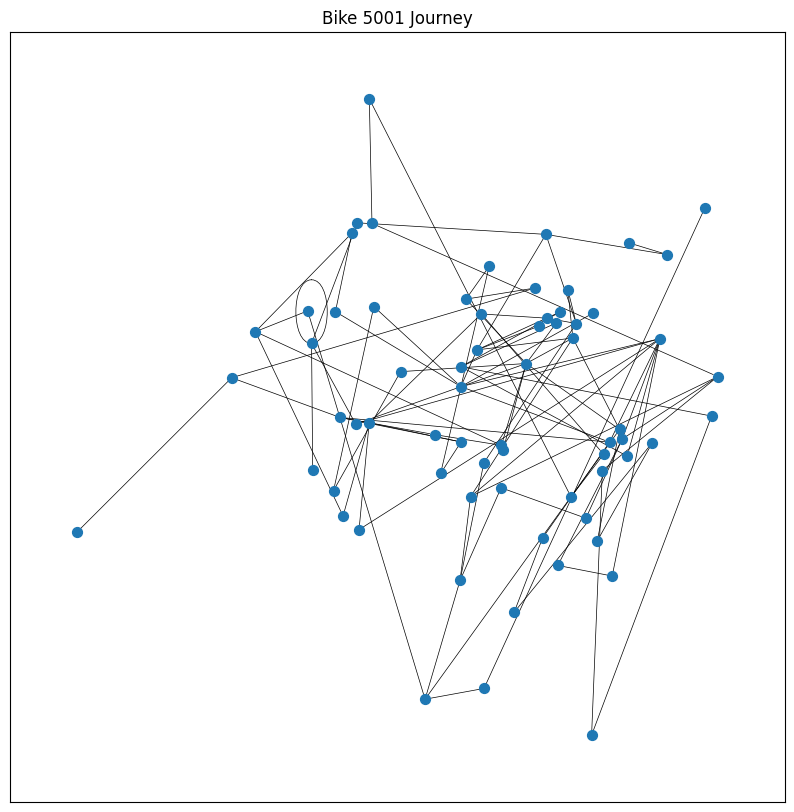

In [69]:
bike5001_network = pd.read_sql("SELECT * FROM bike_5001 ORDER BY starttime LIMIT 100", con)


'''
G = nx.from_pandas_edgelist(question8, 'start_station_name', 'end_station_name', create_using=nx.Graph())  # undirected, unweighted graph
# Create figure
plt.figure(figsize=(15,15), dpi=100)
plt.title("Bike 5001 Journey.")
nx.draw_networkx(G, labels="", node_size=5) #node_color=node_colors, labels=nx_labels, node_size=50, font_size=15)
plt.show()

'''

G = nx.Graph()

#for row in bike5001_network.itertuples(index=False):
for index, row in bike5001_network.iterrows():
  ###G.add_node(row.start_station_name, pos=(row.start_station_longitude, row.start_station_latitude))
  # Add the nodes to the graph
  G.add_node(row.start_station_name, pos=(row.start_station_longitude, row.start_station_latitude))
  G.add_node(row.end_station_name, pos=(row.end_station_longitude, row.end_station_latitude))

  # Add the edge between start_station and end_station
  G.add_edge(row.start_station_name, row.end_station_name)


# Extract the node positions from the graph
node_positions = {node: node_data['pos'] for node, node_data in G.nodes(data=True)}

# Draw the graph
plt.figure(figsize=(10,10), dpi=100)
plt.title("Bike 5001 Journey")


# Change node colors to differentiate genes and diseases
edge_colors = range(100)

nx.draw_networkx(G, pos=node_positions, with_labels=False, arrows=True, node_size=50,
                 width=0.5, font_size=8)#,
                 #edge_cmap = plt.cm.Blues,
                 #edge_color = edge_colors)


plt.show()





#nx.draw(G, nx.get_node_attributes(G, 'pos'),
#        with_labels=False,
#        node_size=20,
#        node_color=range(274),
#        cmap=plt.cm.Blues)


#G2 = nx.from_pandas_edgelist(bike5001_network, 'start_station_name', 'end_station_name', create_using=nx.Graph())
#nx.draw_networkx(G2, labels="", node_size=5) #node_color=node_colors, labels=nx_labels, node_size=50, font_size=15)

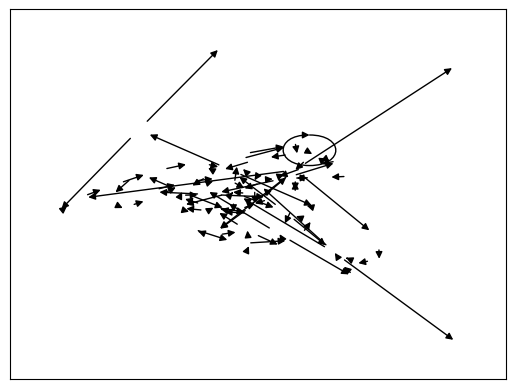

In [23]:
G = nx.DiGraph()

#G.add_edges_from([(1, 2), (1, 3), (2, 3)])

for index, row in bike5001_network.iterrows():
  # Add the edge between start_station and end_station
  G.add_edge(row.start_station_name, row.end_station_name)


arcs = nx.draw_networkx_edges(G, pos=nx.spring_layout(G))

8 stations impacts by 9 inch sea level rise 10 percent storm!
23 stations impacts by 21 inch sea level rise 10 percent storm!
54 stations impacts by 36 inch sea level rise 10 percent storm!


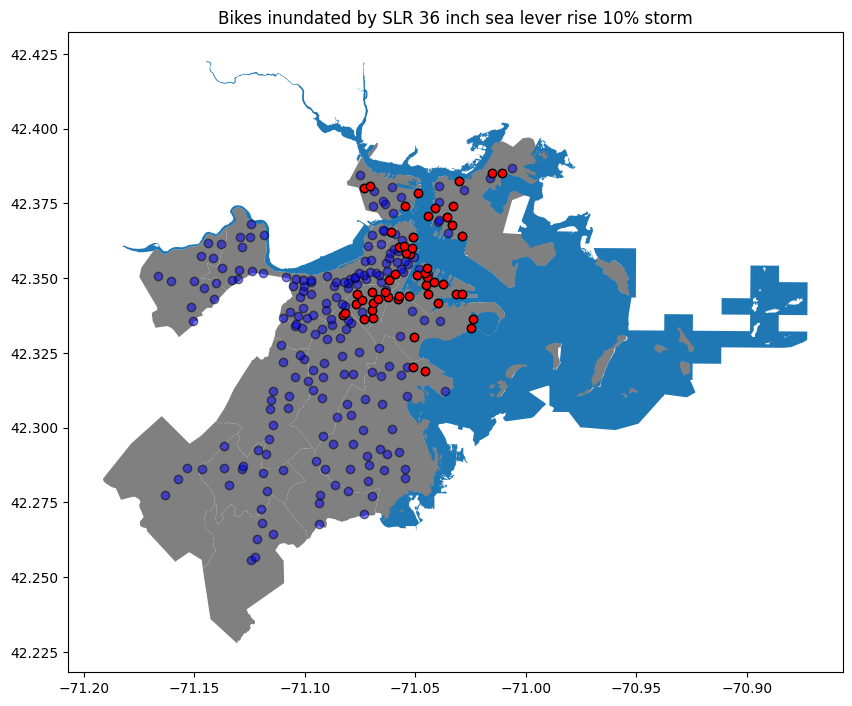

In [147]:
# SEA LEVEL RISE MAPPING AND DATA

# Filter crash data to just bikes
stations = pd.read_sql("SELECT * FROM current_bluebikes_stations", con)

# Mapping a dataframe with lat/long data to a point file
points = [Point(xy) for xy in zip(stations['Longitude'], stations['Latitude'])]
# Convert that point layer into a geodataframe object
stations = gpd.GeoDataFrame(stations, crs="EPSG:4326", geometry=points)



# Add shapefile of Boston Neighborhoods https://data.boston.gov/dataset/boston-neighborhoods
boston_neighborhoods = gpd.read_file(boston_city_shp, type='Polygon')
boston_neighborhoods = boston_neighborhoods.to_crs('EPSG:4326')




# Add 9 inch level rise 10 pct storm
sea_level_9in = gpd.read_file(sea_level_9in_path, type='Polygon')
sea_level_9in = sea_level_9in.to_crs('EPSG:4326')
# Add 21 inch level rise 10 pct storm
sea_level_21in = gpd.read_file(sea_level_21in_path, type='Polygon')
sea_level_21in = sea_level_21in.to_crs('EPSG:4326')
# Add 36 inch level rise 10 pct storm
sea_level_36in = gpd.read_file(sea_level_36in_path, type='Polygon')
sea_level_36in = sea_level_36in.to_crs('EPSG:4326')




clipped_stations = gpd.clip(stations, boston_neighborhoods, keep_geom_type=False)
# Spatially clip the points to the polygons
clipped_stations_SLR9 = gpd.clip(clipped_stations, sea_level_9in, keep_geom_type=False)
clipped_stations_SLR21 = gpd.clip(clipped_stations, sea_level_21in, keep_geom_type=False)
clipped_stations_SLR36 = gpd.clip(clipped_stations, sea_level_36in, keep_geom_type=False)

# number of stations underwater!
print(clipped_stations_SLR9.count()[0], "stations impacts by 9 inch sea level rise 10 percent storm!")
print(clipped_stations_SLR21.count()[0], "stations impacts by 21 inch sea level rise 10 percent storm!")
print(clipped_stations_SLR36.count()[0], "stations impacts by 36 inch sea level rise 10 percent storm!")




# create figure
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
# Neighborhood background map
#nhoods.plot(color='#808080', edgecolor='#000000', ax=ax)  # background plot

# Plot background images
#bike_lanes.plot(ax=ax)
boston_neighborhoods.plot(ax=ax, color='grey', zorder=1)
sea_level_9in.plot(ax=ax, zorder=2)

# Plot data
clipped_stations.plot(edgecolor='#000000', legend=True, categorical=False, ax=ax, color='b', alpha=0.5, zorder=4)
clipped_stations_SLR36.plot(edgecolor='#000000', legend=True, categorical=False, ax=ax, color='r', zorder=4)
plt.title("Statins in Boston inundated by SLR 36 inch sea lever rise 10% storm")
plt.show()


Note to self: Sea level rise next step includes joining inundated stations to the full table, and then getting the number of trips generated from these stations. 

Then, compare the number of trips generated from these stations to the total number of trips taken.

## Alex's Work In Progress Stuff

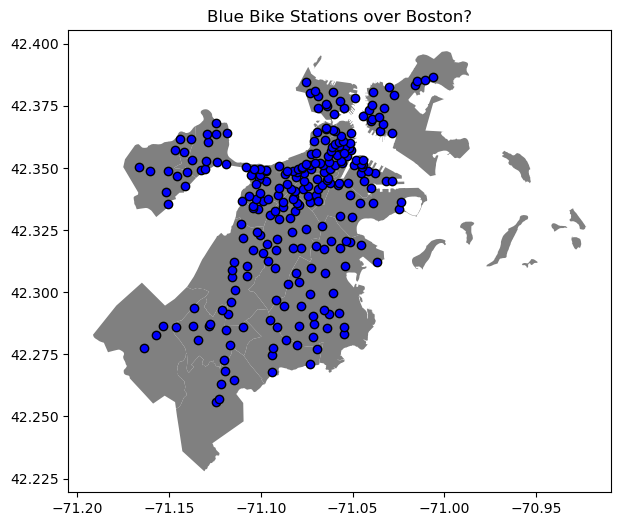

In [7]:
stations = pd.read_sql("SELECT * FROM current_bluebikes_stations", con)

# mapping a dataframe with lat/long data to a point file
points = [Point(xy) for xy in zip(stations['Longitude'], stations['Latitude'])]

# convert that point layer into a geodataframe object
stations = gpd.GeoDataFrame(stations, crs="EPSG:4326", geometry=points)

# shapefile of Boston Neighborhoods https://data.boston.gov/dataset/boston-neighborhoods
boston_neighborhoods = gpd.read_file(boston_city_shp, type='Polygon')
boston_neighborhoods = boston_neighborhoods.to_crs('EPSG:4326')

# clip stations to the boston neighborhood map
clipped_stations = gpd.clip(stations, boston_neighborhoods, keep_geom_type=False)

# create figure
fig, ax = plt.subplots(figsize=(7, 7))

# Plot map
boston_neighborhoods.plot(ax=ax, color='grey')

# plot station data
clipped_stations.plot(edgecolor='#000000', legend=True, categorical=False, ax=ax, color='b')
plt.title("Blue Bike Stations over Boston?")
plt.show()

Nothing crazy just basic incase we need it for our report.

/var/folders/vs/p96pv22d4p73j4j84xb9k3zr0000gn/T/ipykernel_2573/927161265.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crash_data['geometry'] = [Point(xy) for xy in zip(crash_data['long'], crash_data['lat'])]


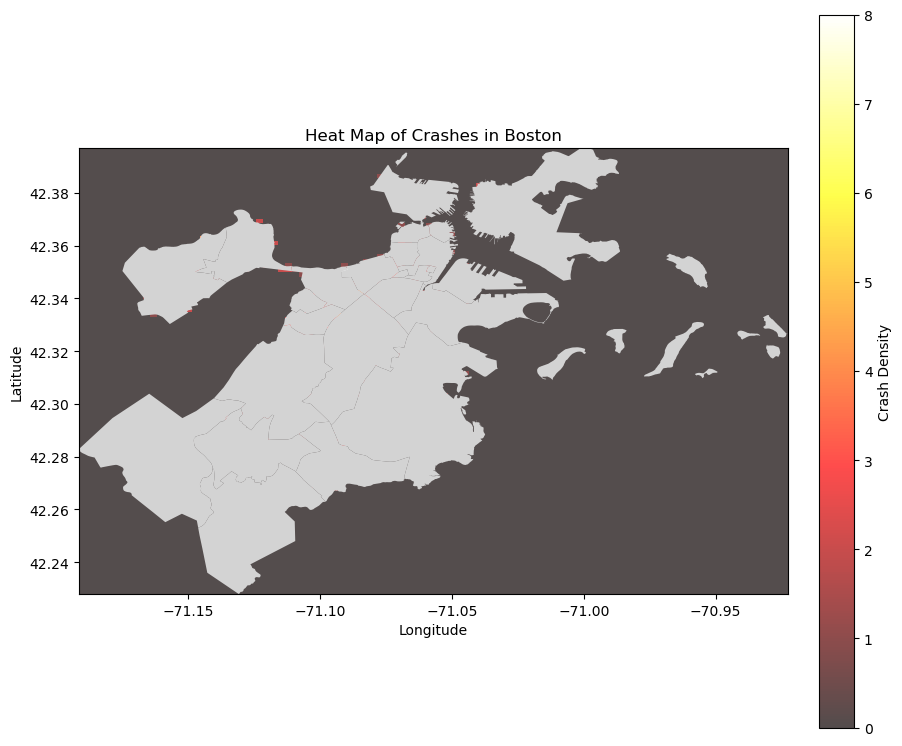

In [38]:
# Filter crash data to just bikes
crash_data = boston_crashes_2017[boston_crashes_2017["mode_type"] == 'bike']

# Add shapefile of Boston Neighborhoods https://data.boston.gov/dataset/boston-neighborhoods
boston_map = gpd.read_file(boston_city_shp, type='Polygon')
boston_map = boston_map.to_crs('EPSG:4326')

# Step 2: Prepare the Data
crash_data['geometry'] = [Point(xy) for xy in zip(crash_data['long'], crash_data['lat'])]
crash_data = gpd.GeoDataFrame(crash_data, geometry='geometry')


# Step 3: Prepare the Data
xmin, ymin, xmax, ymax = boston_map.total_bounds
density, x_edges, y_edges = np.histogram2d(
    crash_data.geometry.x, crash_data.geometry.y,
    bins=100, range=[[xmin, xmax], [ymin, ymax]]
)

# Plot the Map and Heat Map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the  Map of Boston
boston_map.plot(ax=ax, color='lightgray')

# Plot the Heat Map
extent = [xmin, xmax, ymin, ymax]
im = ax.imshow(density.T, origin='lower', extent=extent, cmap='hot', alpha=0.7)

# Add a Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Crash Density')

plt.title('Heat Map of Crashes in Boston')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# issue: heat map is being plotted under the map of boston
# issue: not really a heat map more of a histogram of where crashes are occuring? 
# not really what I wanted to make? I used geoplots to create

I was trying to create a heatmap of crashes over boston, but I used geoplots in my homework 2 and it managed to uninstall from my laptop lol. 

Did you make a heat map for HW 2? If so what did you use

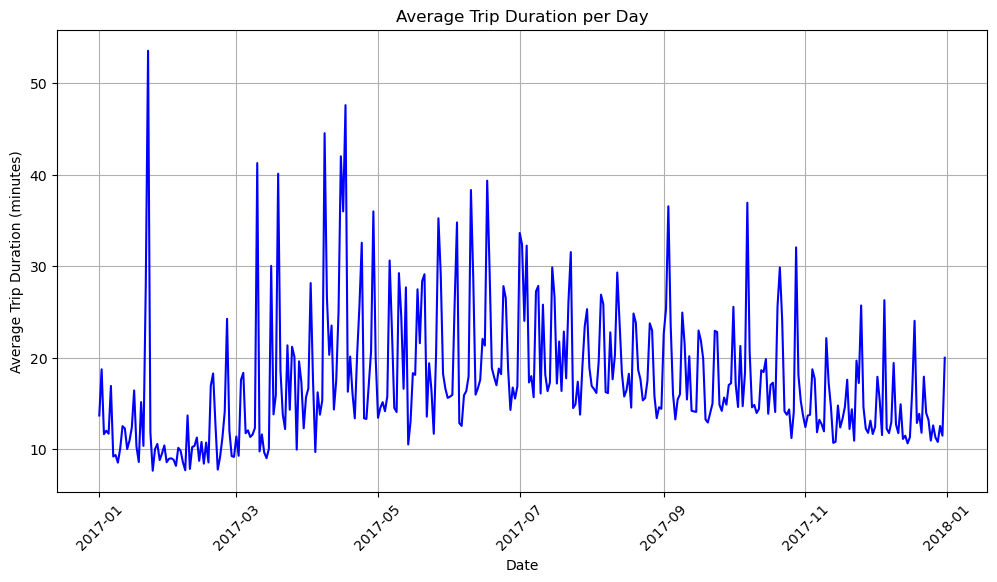

In [58]:
## Avg. Duration by Day -- not super relevent to us  --- if we do use this I will add a yearly average line in

blue_bike_trip_data = pd.read_sql("SELECT tripduration, starttime, stoptime FROM bluebike_trips2017", con)

# change to date types in pd
blue_bike_trip_data['starttime'] = pd.to_datetime(blue_bike_trip_data['starttime'])
blue_bike_trip_data['stoptime'] = pd.to_datetime(blue_bike_trip_data['stoptime'])

# convert trip duration from seconds to minutes
blue_bike_trip_data['tripduration'] = blue_bike_trip_data['tripduration'] / 60

# calculate average daily trip duration
daily_avg_trip_duration = blue_bike_trip_data.groupby(blue_bike_trip_data['starttime'].dt.date)['tripduration'].mean()

# plot
plt.figure(figsize=(12, 6))
plt.plot(daily_avg_trip_duration.index, daily_avg_trip_duration, color='blue')

plt.title('Average Trip Duration per Day')
plt.xlabel('Date')
plt.ylabel('Average Trip Duration (minutes)')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

In [70]:
## Attempt in show average distance from each station  -- need to fix the merge 

# query data
blue_bike_trip_data = pd.read_sql("SELECT * FROM bluebike_trips2022", con)
blue_bike_station_data =  pd.read_sql("SELECT * FROM current_bluebikes_stations", con)


# calcaulate avg & group 
station_duration_data = blue_bike_trip_data.groupby(['start_station_id', 'end_station_id'])['tripduration'].mean().reset_index()

# create geo for stations 
start_station_mapping = blue_bike_station_data[['station_id', 'start_station_latitude', 'start_station_longitude']]
start_station_mapping = start_station_mapping.rename(columns={'start_station_latitude': 'latitude_start', 'start_station_longitude': 'longitude_start'})
end_station_mapping = blue_bike_station_data[['station_id', 'end_station_latitude', 'end_station_longitude']]
end_station_mapping = end_station_mapping.rename(columns={'end_station_latitude': 'latitude_end', 'end_station_longitude': 'longitude_end'})

# join trip with station data 
station_duration_data = station_duration_data.join(start_station_mapping.set_index('station_id'), on='start_station_id')
station_duration_data = station_duration_data.join(end_station_mapping.set_index('station_id'), on='end_station_id')

# Step 4: Create Geographical Plot
gdf = gpd.GeoDataFrame(station_duration_data, geometry=gpd.points_from_xy(station_duration_data['longitude_start'], station_duration_data['latitude_start']))

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='tripduration', cmap='viridis', ax=ax, markersize=10, legend=True)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Average Trip Duration by Station Pair')

plt.show()

KeyError: ('station_id', 'start_station_latitude', 'start_station_longitude')

Viz ideas:
Heatmaps: how the most popular bike trip routes based on start and end stations
Heatmaps: show heat map of crashes in boston
Time of day people are biking by when crashes occur? - 
Number of crashes over time, see if like time has reduced number of crashes - timeseries

Table: 
station & average distance 

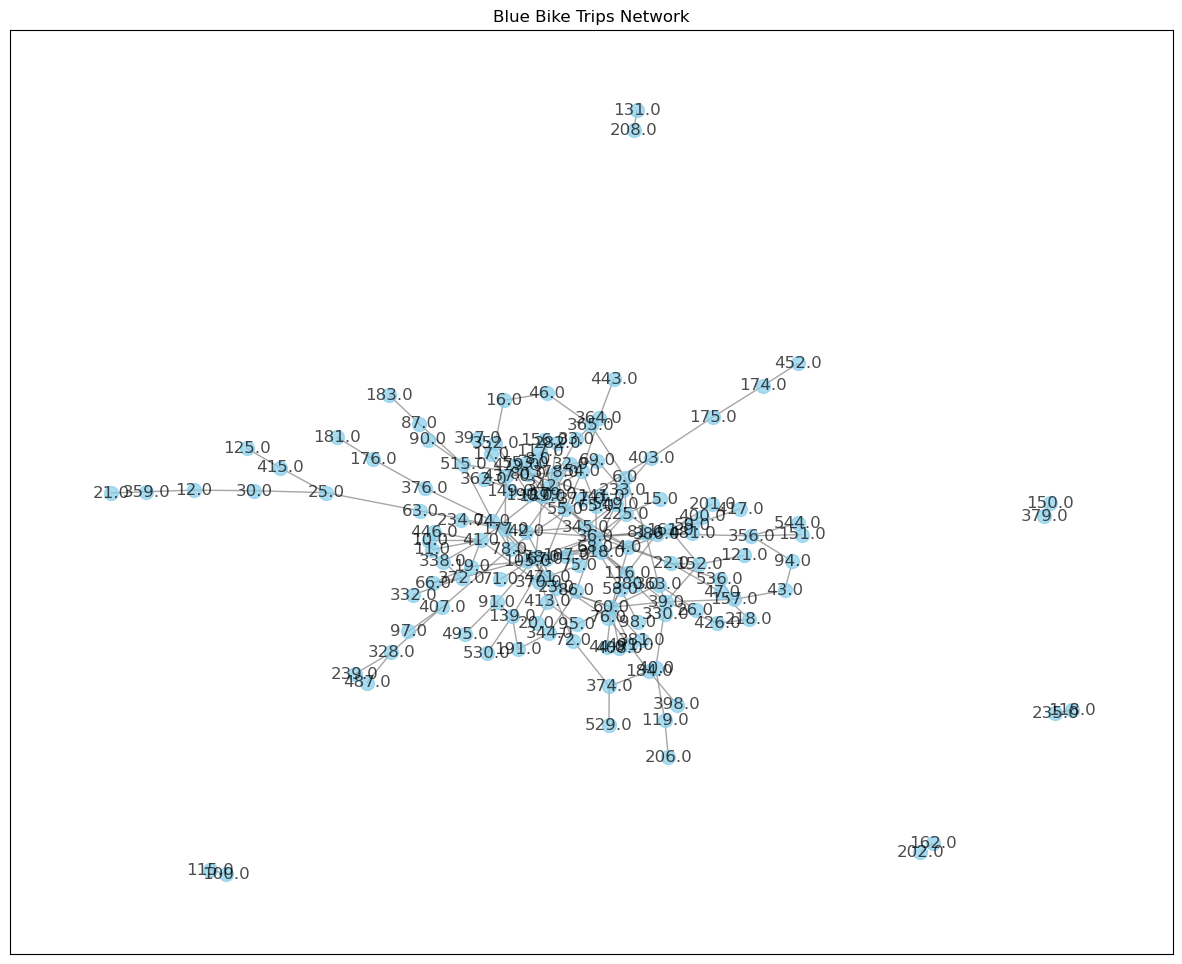

In [82]:
## showing a network of 250 trips--- excluding when people start and end at the same station

## I want to plot this network over our map of boston

blue_bike_trip_data = pd.read_sql("SELECT start_station_latitude, start_station_longitude, start_station_id, end_station_id, end_station_latitude, end_station_longitude  FROM bluebike_trips2022", con)

bike_network = nx.Graph()
# Iterate over the trip data and add edges to the network
count = 0
for _, trip in blue_bike_trip_data.iterrows():
    ## if stat station long is wihtin -71.2 and -70.95, and start station lat is within 42.2 and 42.40
    if (42.20 <= trip['start_station_latitude'] <= 42.40) and (-71.2 <= trip['start_station_longitude'] <= -70.95) and (42.20 <= trip['end_station_latitude'] <= 42.40) and (-71.2 <= trip['end_station_longitude'] <= -70.95):
    
    
        start_station = trip['start_station_id']
        end_station = trip['end_station_id']
        ## exclude trip when people start and end at the same station ()
        if trip['start_station_id'] != trip['end_station_id']:
            bike_network.add_edge(start_station, end_station)
            count = count +1
        
    if count >= 250:
        break

# Plot the network
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(bike_network, seed=42)
nx.draw_networkx(bike_network, pos, node_size=100, node_color='skyblue', edge_color='gray', alpha=0.7)

plt.title('Blue Bike Trips Network')
plt.legend
plt.axis()
plt.show()

Network of 250 blue bike trips in 2022. Not including bikes that start and end at the same station. This is looking at who is comuting where. It would be cool to plot this over the map of boston but idk if I can figure that out in time. 

Need to add station names, so that we can actual see where people are going if we just keep this network view

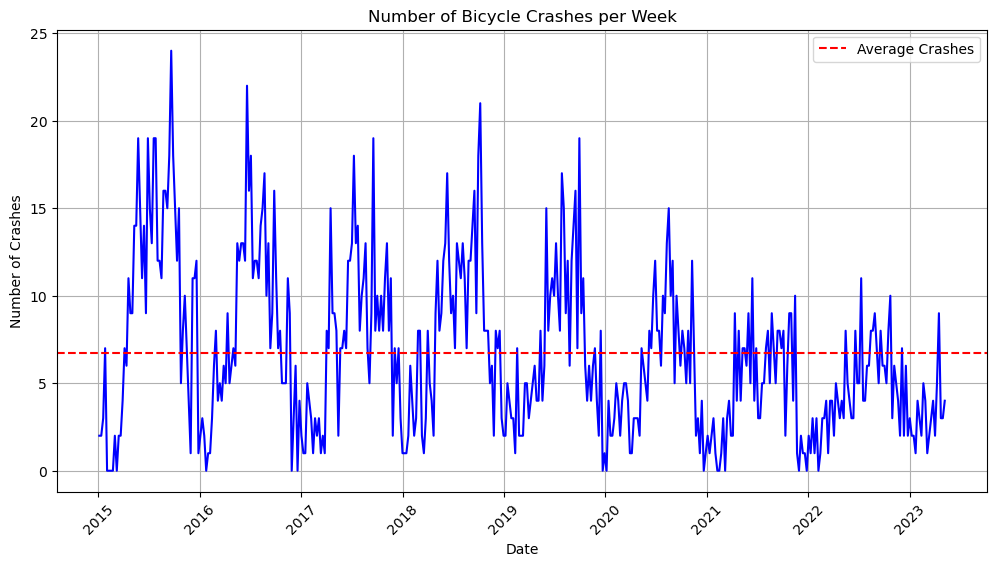

In [87]:
bos_crashes = pd.read_sql("SELECT * FROM boston_crash_reports", con)
bos_crashes = bos_crashes[bos_crashes["mode_type"] == 'bike'] #filter to just 

# convert column to datetime
bos_crashes['dispatch_ts'] = pd.to_datetime(bos_crashes['dispatch_ts'])

# group by week and count the number of crashes per week
crashes_per_week = bos_crashes.groupby(pd.Grouper(key='dispatch_ts', freq='W')).size()

# calculate the average crashes per week
average_crashes = crashes_per_week.mean()

# plot 
plt.figure(figsize=(12, 6))
plt.plot(crashes_per_week.index, crashes_per_week, color='blue')
plt.axhline(y=average_crashes, color='red', linestyle='--', label='Average Crashes')

plt.title('Number of Bicycle Crashes per Week')
plt.xlabel('Date')
plt.ylabel('Number of Crashes')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()


Kind of intresting to look at. I have seen things saying a lot of the bike lanes are new so it could be that new bike lanes are decreasing crashes, or less people are reporting crashes to the police. ? Not really sure how we will be able to use this


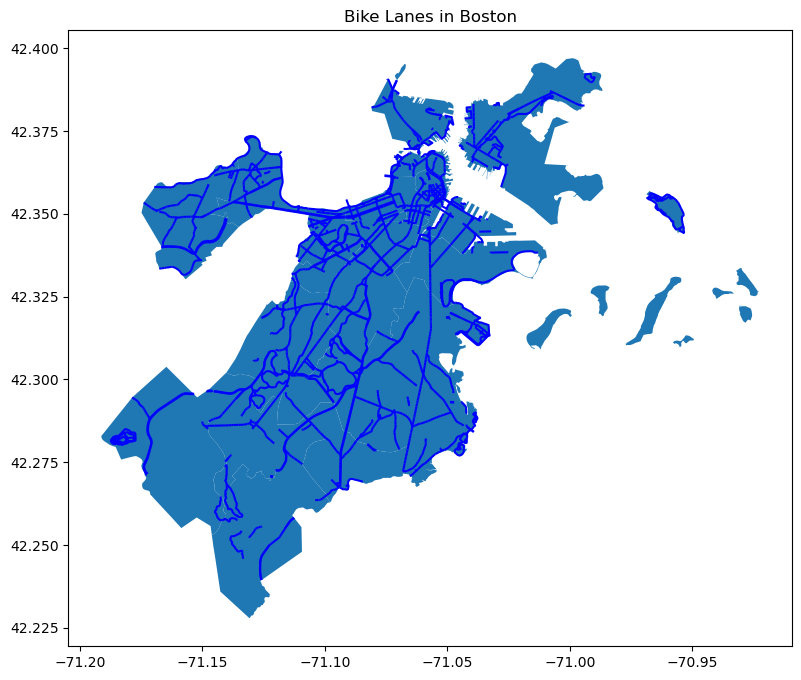

In [100]:
## Trying to show the bike lanes affected by climate change 
## -- working on a way to show bike lanes that will be affected?

# Add shapefile of Boston Neighborhoods https://data.boston.gov/dataset/boston-neighborhoods
city_map = gpd.read_file(boston_city_shp, type='Polygon')
city_map = boston_map.to_crs('EPSG:4326')

# Read the bike lanes data
bike_lanes = gpd.read_file(bike_lanes_geojson)

# Read the sea level rise data
sea_level_rise = gpd.read_file(sea_level_36in_path)

# Create a single plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the city map
city_map.plot(ax=ax)

# Plotting all bike lanes
bike_lanes.plot(ax=ax, color='blue')

# Set the title and display the plot
plt.title('Bike Lanes in Boston')
plt.show()